In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt 
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score

In [2]:
#for java mongodb+srv://elije465:<password>@cluster0.zsn5y.mongodb.net/myFirstDatabase?retryWrites=true&w=majority

HOST = 'cluster0.zsn5y.mongodb.net'
USER = 'elije465'
PASSWORD = '465684'
DATABASE_NAME = 'LOL'
COLLECTION_NAME = 'puuid'
MONGO_URI = f"mongodb+srv://{USER}:{PASSWORD}@{HOST}/{DATABASE_NAME}?retryWrites=true&w=majority&ssl=true&ssl_cert_reqs=CERT_NONE"
client = MongoClient(MONGO_URI) #몽고 클라이언트(라이브러리) 몽고URI를 가져올수있게 도와줌 에 몽고 URI를 연결한다
database=client[DATABASE_NAME]#DATABSE, 연결된 클라이언트에 데이터베이스를 연결
collection=database[COLLECTION_NAME]#TABLE, 연결된 데이터베이스에 콜렉션을 연결
coll_sid=database['sid']
coll_matchid=database['matchid']
coll_gamedata=database['gamedata']


In [3]:
def get_gamedata():
    """ 
    mongo에서 gamedata를 가져와서 df로 변환해줍니다
    """        
    df=pd.DataFrame()
    gamedata=coll_gamedata.find({"index":"index"})
    for x in gamedata:
        df=pd.concat([df,pd.DataFrame(x['data'])],axis=0)
    return df
df=get_gamedata()

In [4]:
df.to_csv(f'gamedata_fordatabase.csv',index=False,encoding='cp949') 

In [5]:
""" 
먼저 결측값에 대해 보자
생각보다 많이나왔다
먼저 특이한건 blue와 red의 결측치의 열과 숫자가 정확히 똑같다
"""
df.isnull().sum()


damageStats_blue               0
goldPerSecond_blue             0
jungleMinionsKilled_blue       0
level_blue                     0
minionsKilled_blue             0
totalGold_blue                 0
xp_blue                        0
kill_blue                      2
death_blue                     2
assi_blue                      2
tower_blue                  6229
tower_shield_blue              0
win_blue                       1
damageStats_red                0
goldPerSecond_red              0
jungleMinionsKilled_red        0
level_red                      0
minionsKilled_red              0
totalGold_red                  0
xp_red                         0
kill_red                       2
death_red                      2
assi_red                       2
tower_red                   6229
tower_shield_red               0
win_red                        1
dragon_blue                 1942
junr_blue                   1842
dragon_red                  1942
junr_red                    1842
dtype: int

In [6]:
"""
15분동안 충분히 서로 못가져가는 게임이 나올수있다 그런데 왜 정확히 똑같을까?
그문제는 한쪽이라도 용이든 타워를 가져가면 그 열이 생성되는데 아무것도 못가져간 반대쪽도 이미 열이 있기떄문에 0이 출력된다
하지만 서로 못가져가면 열이생성되지않을 상태에서 concat으로 붙이게되면 nan이 출력되는것이다 고로 그냥 다 0으로 처리해도된다고 본다
"""
df.loc[df['tower_red'].isnull()]

,damageStats_blue,goldPerSecond_blue,jungleMinionsKilled_blue,level_blue,minionsKilled_blue,totalGold_blue,xp_blue,kill_blue,death_blue,assi_blue,...,kill_red,death_red,assi_red,tower_red,tower_shield_red,win_red,dragon_blue,junr_blue,dragon_red,junr_red
0,35159,30,68,47,323,28343,30778,14.0,11.0,12.0,...,11.0,14.0,10.0,NaN,6.0,0.0,1.0,1.0,0.0,0.0
0,18468,30,97,48,378,25091,30988,6.0,3.0,11.0,...,3.0,6.0,2.0,NaN,5.0,0.0,1.0,0.0,1.0,1.0
0,26209,30,68,46,415,28026,29952,11.0,10.0,19.0,...,10.0,11.0,16.0,NaN,2.0,0.0,0.0,1.0,1.0,0.0
0,35538,30,81,45,361,27504,28868,13.0,14.0,10.0,...,14.0,13.0,16.0,NaN,4.0,0.0,2.0,NaN,0.0,NaN
0,25806,30,86,45,347,26183,27580,10.0,5.0,17.0,...,5.0,10.0,6.0,NaN,5.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,30262,30,76,45,318,24237,27532,9.0,8.0,10.0,...,8.0,9.0,8.0,NaN,3.0,1.0,1.0,NaN,0.0,NaN
0,26196,20,87,46,372,27527,30207,9.0,17.0,13.0,...,17.0,9.0,20.0,NaN,4.0,1.0,0.0,1.0,2.0,0.0
0,34450,30,92,47,374,28730,30270,17.0,10.0,13.0,...,10.0,17.0,13.0,NaN,0.0,1.0,0.0,NaN,2.0,NaN
0,16759,30,84,45,373,22149,27382,2.0,9.0,2.0,...,9.0,2.0,15.0,NaN,7.0,1.0,NaN,NaN,NaN,NaN


In [7]:
df=df.fillna(0)
df.isnull().sum()

damageStats_blue            0
goldPerSecond_blue          0
jungleMinionsKilled_blue    0
level_blue                  0
minionsKilled_blue          0
totalGold_blue              0
xp_blue                     0
kill_blue                   0
death_blue                  0
assi_blue                   0
tower_blue                  0
tower_shield_blue           0
win_blue                    0
damageStats_red             0
goldPerSecond_red           0
jungleMinionsKilled_red     0
level_red                   0
minionsKilled_red           0
totalGold_red               0
xp_red                      0
kill_red                    0
death_red                   0
assi_red                    0
tower_red                   0
tower_shield_red            0
win_red                     0
dragon_blue                 0
junr_blue                   0
dragon_red                  0
junr_red                    0
dtype: int64

In [8]:
""" 
win_blue를 체크해본다 사실상 win_red와 정반대의 결과라서 하나만 보면 충분하다
사실상 결과는 거의 반반이다
"""
df['win_blue'].value_counts(normalize=True)


0.0    0.506503
1.0    0.493497
Name: win_blue, dtype: float64

' \nlevel 과 xp는 사실상 같은 것-xp 삭제\n팀의 킬과 상대편의 데스는 사실상같다 원래는 각 개인의 킬데스를 위해 넣었지만 팀으로 되면서 의미가없어졌다-데스삭제\ngoldpersecond 이게 대체 뭔지모르겠다.. 초당 골드같은데 분별력이없는느낌..?\n총 골드량과 킬은 높은 상관관계가있다 초반의 골드량은 킬이 큰 관여를 한다\nwin_red를 드랍하기로했다 어차피 win_blue만있어도 충분하다\n'

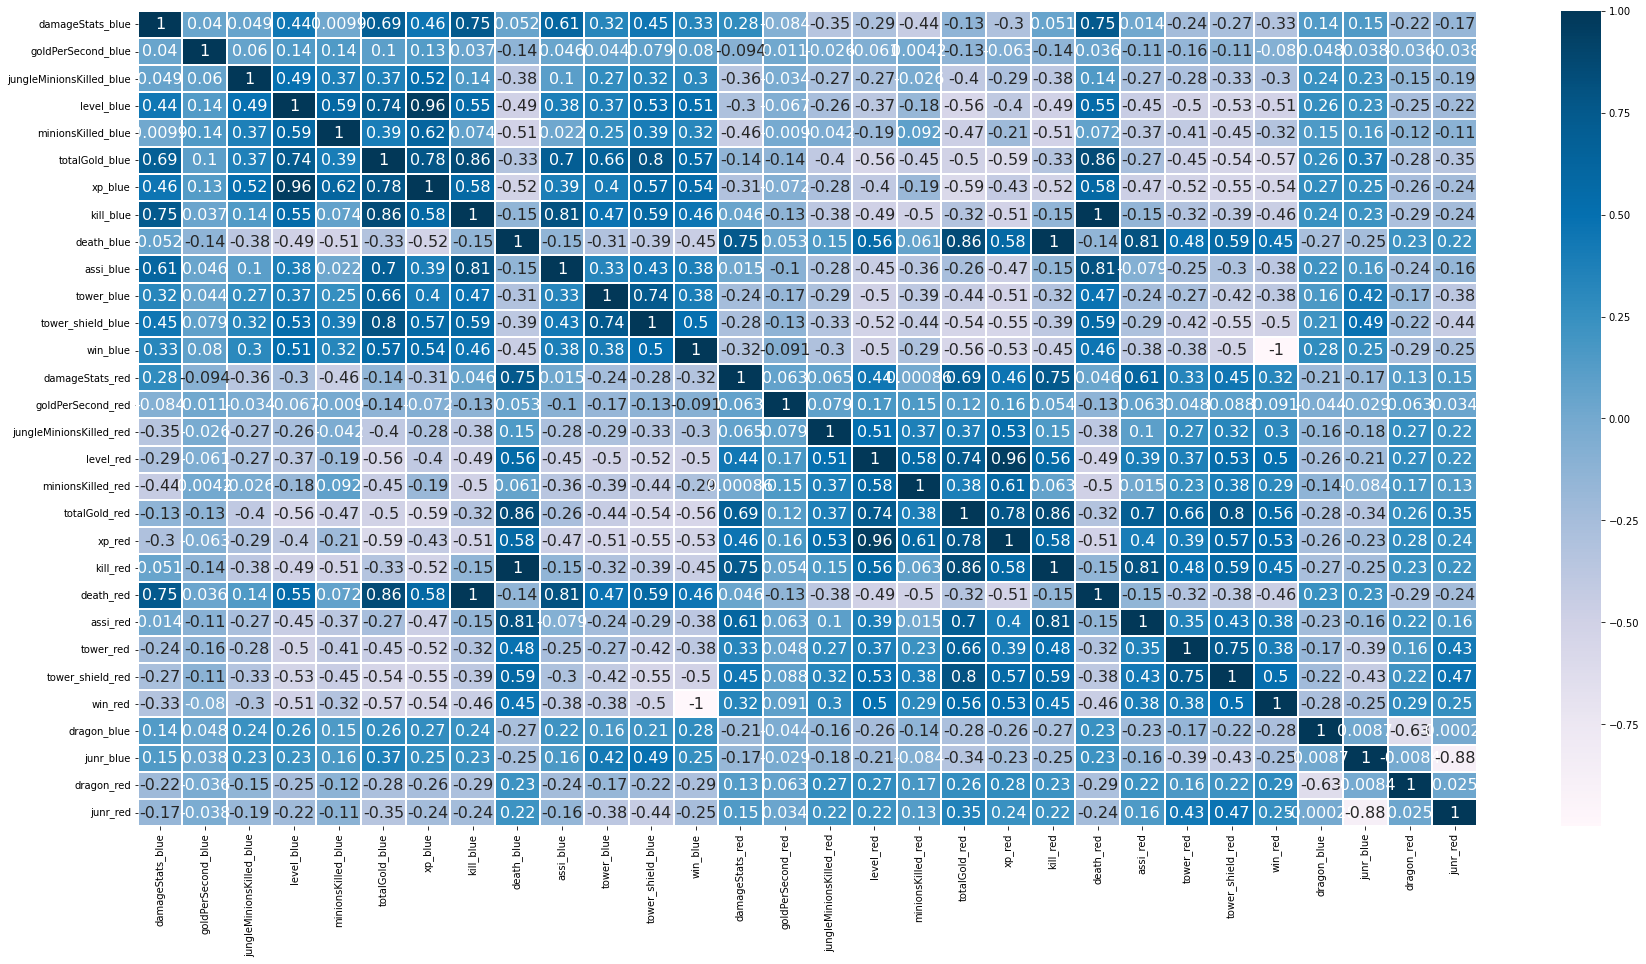

In [9]:
colormap=plt.cm.PuBu
plt.figure(figsize=(30,15))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0,square=False,cmap=colormap,linecolor='white',annot=True,annot_kws={'size':16})
""" 
level 과 xp는 사실상 같은 것-xp 삭제
팀의 킬과 상대편의 데스는 사실상같다 원래는 각 개인의 킬데스를 위해 넣었지만 팀으로 되면서 의미가없어졌다-데스삭제
goldpersecond 이게 대체 뭔지모르겠다.. 초당 골드같은데 분별력이없는느낌..?
총 골드량과 킬은 높은 상관관계가있다 초반의 골드량은 킬이 큰 관여를 한다
win_red를 드랍하기로했다 어차피 win_blue만있어도 충분하다
"""

<AxesSubplot:>

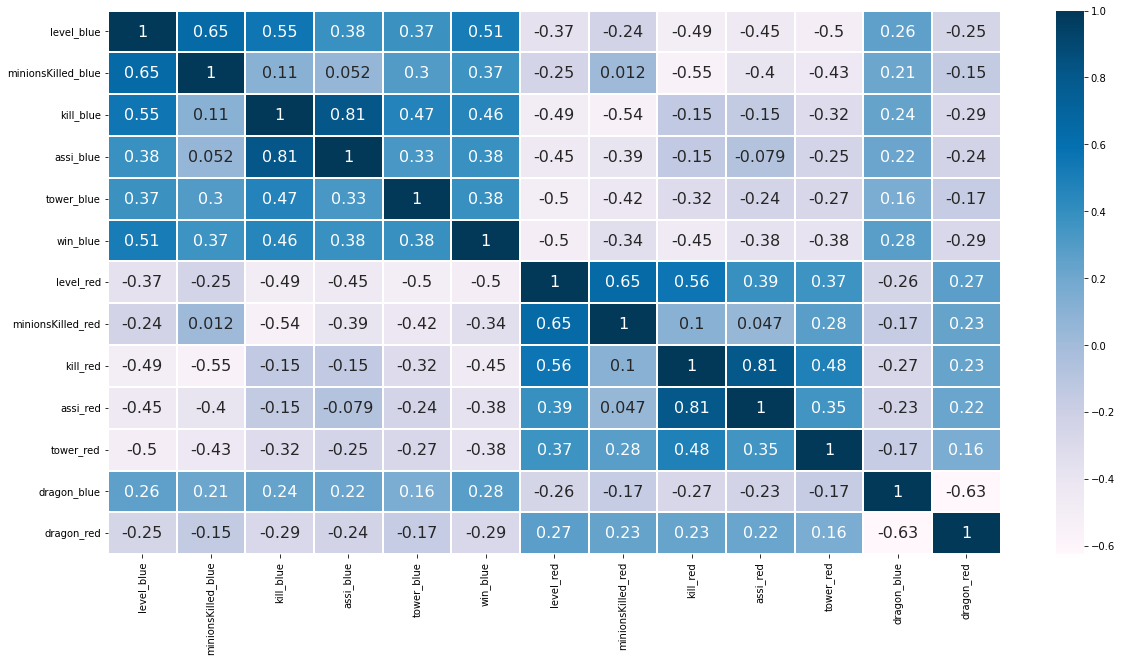

In [10]:
df['minionsKilled_blue']=df['minionsKilled_blue']+df['jungleMinionsKilled_blue']
df['minionsKilled_red']=df['minionsKilled_red']+df['jungleMinionsKilled_red']
df=df.drop(['jungleMinionsKilled_blue','jungleMinionsKilled_red','xp_blue','xp_red','death_blue','death_red','win_red','totalGold_blue','damageStats_blue','tower_shield_blue','goldPerSecond_blue','junr_blue','totalGold_red','damageStats_red','tower_shield_red','goldPerSecond_red','junr_red'],axis=1)
""" 
사실상 인게임에서 알수없는건 빼버렸고 정글몹과 미니언은 하나로 통일
"""
colormap=plt.cm.PuBu
plt.figure(figsize=(20 ,10))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0,square=False,cmap=colormap,linecolor='white',annot=True,annot_kws={'size':16})


In [11]:
"""
randomforest로 1차 값을 꺼내 변수중요도를 볼것예정이다
먼저 train test vali를 나눈다
"""
train,test=train_test_split(df,train_size=0.8,random_state=2)
train,vali=train_test_split(train,train_size=0.8,random_state=2)
train.shape,vali.shape,test.shape

((18402, 13), (4601, 13), (5751, 13))

In [12]:
""" 
타겟과 뭐지.. 여튼 나눔
"""

target='win_blue'
def split_xy(data):
    """변수이름 어떻게 다르게 출력하지..?"""
    y=data[target]
    x=data.drop(target,axis=1)
    return y,x
y_train,X_train=split_xy(train)
y_vali,X_vali=split_xy(vali)
y_test,X_test=split_xy(test)



In [13]:
rf=RandomForestClassifier(n_estimators=500,random_state=2,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=2)

In [14]:
rf.score(X_train,y_train),rf.score(X_vali,y_vali)

(1.0, 0.7965659639208867)

In [15]:
space={'max_depth': hp.quniform("max_depth", 3, 20, 1), #마지막 옵션으로 나눈후 정수 반환
        'gamma': hp.uniform ('gamma', 0,100), #사이의 실수값 반환
        'reg_alpha' : hp.uniform('reg_alpha', 0,100),
        'reg_lambda' : hp.uniform('reg_lambda', 0,100),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 200, 1500, 100),
        'seed': 0,
        'learning_rate':hp.uniform ('learning_rate',0,1)
    }
def objective(space):
    clf=XGBClassifier(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'],reg_lambda = space['reg_alpha'],min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=space['colsample_bytree'])
    #실수가들어가야하는값은 int변환
    eval = [( X_train, y_train), ( X_vali, y_vali)]
    
    clf.fit(X_train, y_train,
            eval_set=eval, eval_metric="auc",
            early_stopping_rounds=50,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    #print ("SCORE:", accuracy)    
    return {'loss': -accuracy, 'status': STATUS_OK }

In [16]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 300,
                        trials = trials)

  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  0%|          | 1/300 [00:00<03:22,  1.48trial/s, best loss: -0.7944705268648931]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  1%|          | 2/300 [00:01<03:59,  1.25trial/s, best loss: -0.7944705268648931]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  1%|          | 3/300 [00:02<03:21,  1.48trial/s, best loss: -0.7949921752738655]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  1%|▏         | 4/300 [00:02<03:02,  1.62trial/s, best loss: -0.7951660580768563]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  2%|▏         | 5/300 [00:03<02:55,  1.68trial/s, best loss: -0.800208659363589] 

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  2%|▏         | 6/300 [00:03<03:09,  1.55trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  2%|▏         | 7/300 [00:04<03:34,  1.37trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  3%|▎         | 8/300 [00:05<03:18,  1.47trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  3%|▎         | 9/300 [00:05<03:07,  1.55trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  3%|▎         | 10/300 [00:06<02:58,  1.63trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  4%|▎         | 11/300 [00:07<03:03,  1.58trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  4%|▍         | 12/300 [00:07<03:03,  1.57trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  4%|▍         | 13/300 [00:08<02:52,  1.66trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  5%|▍         | 14/300 [00:08<02:50,  1.68trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  5%|▌         | 15/300 [00:09<02:47,  1.70trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  5%|▌         | 16/300 [00:10<02:48,  1.68trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  6%|▌         | 17/300 [00:10<03:11,  1.48trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  6%|▌         | 18/300 [00:11<02:50,  1.65trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  6%|▋         | 19/300 [00:11<02:45,  1.70trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  7%|▋         | 20/300 [00:12<02:43,  1.71trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  7%|▋         | 21/300 [00:13<02:44,  1.70trial/s, best loss: -0.800208659363589]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  7%|▋         | 22/300 [00:14<03:53,  1.19trial/s, best loss: -0.8003825421665798]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  8%|▊         | 23/300 [00:15<04:19,  1.07trial/s, best loss: -0.8003825421665798]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  8%|▊         | 24/300 [00:16<03:37,  1.27trial/s, best loss: -0.8003825421665798]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  8%|▊         | 25/300 [00:16<03:14,  1.41trial/s, best loss: -0.8003825421665798]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  9%|▊         | 26/300 [00:17<03:24,  1.34trial/s, best loss: -0.8003825421665798]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  9%|▉         | 27/300 [00:18<03:57,  1.15trial/s, best loss: -0.8003825421665798]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  9%|▉         | 28/300 [00:19<03:36,  1.25trial/s, best loss: -0.8003825421665798]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 10%|▉         | 29/300 [00:19<03:11,  1.42trial/s, best loss: -0.8003825421665798]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 10%|█         | 30/300 [00:20<03:12,  1.40trial/s, best loss: -0.8003825421665798]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 10%|█         | 31/300 [00:21<02:59,  1.50trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 11%|█         | 32/300 [00:21<02:54,  1.53trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 11%|█         | 33/300 [00:22<02:40,  1.66trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 11%|█▏        | 34/300 [00:22<02:29,  1.78trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 12%|█▏        | 35/300 [00:23<02:27,  1.80trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 12%|█▏        | 36/300 [00:23<02:33,  1.72trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 12%|█▏        | 37/300 [00:24<02:29,  1.76trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 13%|█▎        | 38/300 [00:25<03:32,  1.23trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 13%|█▎        | 39/300 [00:26<03:18,  1.31trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 13%|█▎        | 40/300 [00:26<02:57,  1.47trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 14%|█▎        | 41/300 [00:27<03:06,  1.39trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 14%|█▍        | 42/300 [00:28<03:02,  1.41trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 14%|█▍        | 43/300 [00:29<03:03,  1.40trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 15%|█▍        | 44/300 [00:29<02:48,  1.52trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 15%|█▌        | 45/300 [00:30<02:37,  1.61trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 15%|█▌        | 46/300 [00:30<02:25,  1.75trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 16%|█▌        | 47/300 [00:31<02:37,  1.61trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 16%|█▌        | 48/300 [00:31<02:28,  1.70trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 16%|█▋        | 49/300 [00:32<02:32,  1.64trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 17%|█▋        | 50/300 [00:32<02:19,  1.80trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 17%|█▋        | 51/300 [00:33<02:21,  1.76trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 17%|█▋        | 52/300 [00:34<02:45,  1.50trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 18%|█▊        | 53/300 [00:35<03:00,  1.37trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 18%|█▊        | 54/300 [00:35<02:47,  1.47trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 18%|█▊        | 55/300 [00:36<02:38,  1.55trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 19%|█▊        | 56/300 [00:37<02:27,  1.65trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 19%|█▉        | 57/300 [00:38<02:58,  1.36trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 19%|█▉        | 58/300 [00:38<02:43,  1.48trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 20%|█▉        | 59/300 [00:39<02:37,  1.53trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 20%|██        | 60/300 [00:39<02:22,  1.68trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 20%|██        | 61/300 [00:40<02:23,  1.66trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 21%|██        | 62/300 [00:40<02:25,  1.63trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 21%|██        | 63/300 [00:41<02:34,  1.53trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 21%|██▏       | 64/300 [00:42<02:23,  1.64trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 22%|██▏       | 65/300 [00:42<02:18,  1.69trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 22%|██▏       | 66/300 [00:43<02:16,  1.72trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 22%|██▏       | 67/300 [00:44<02:43,  1.43trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 23%|██▎       | 68/300 [00:44<02:36,  1.49trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 23%|██▎       | 69/300 [00:45<02:43,  1.42trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 23%|██▎       | 70/300 [00:46<02:42,  1.42trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 24%|██▎       | 71/300 [00:46<02:37,  1.45trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 24%|██▍       | 72/300 [00:47<02:27,  1.55trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 24%|██▍       | 73/300 [00:47<02:15,  1.68trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 25%|██▍       | 74/300 [00:48<02:13,  1.69trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 25%|██▌       | 75/300 [00:49<02:16,  1.65trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 25%|██▌       | 76/300 [00:49<02:19,  1.60trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 26%|██▌       | 77/300 [00:50<02:13,  1.68trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 26%|██▌       | 78/300 [00:51<02:33,  1.44trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 26%|██▋       | 79/300 [00:52<02:44,  1.35trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 27%|██▋       | 80/300 [00:52<02:28,  1.48trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 27%|██▋       | 81/300 [00:53<02:17,  1.60trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 27%|██▋       | 82/300 [00:53<02:23,  1.52trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 28%|██▊       | 83/300 [00:54<02:21,  1.53trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 28%|██▊       | 84/300 [00:55<02:16,  1.59trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 28%|██▊       | 85/300 [00:55<02:09,  1.67trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 29%|██▊       | 86/300 [00:56<02:11,  1.63trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 29%|██▉       | 87/300 [00:57<02:14,  1.58trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 29%|██▉       | 88/300 [00:57<02:19,  1.52trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 30%|██▉       | 89/300 [00:58<02:18,  1.53trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 30%|███       | 90/300 [00:59<02:20,  1.49trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 30%|███       | 91/300 [01:00<02:49,  1.23trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 31%|███       | 92/300 [01:01<03:05,  1.12trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 31%|███       | 93/300 [01:02<03:17,  1.05trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 31%|███▏      | 94/300 [01:03<03:12,  1.07trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 32%|███▏      | 95/300 [01:04<02:57,  1.16trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 32%|███▏      | 96/300 [01:04<02:37,  1.30trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 32%|███▏      | 97/300 [01:05<02:37,  1.29trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 33%|███▎      | 98/300 [01:05<02:27,  1.37trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 33%|███▎      | 99/300 [01:06<02:25,  1.38trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 33%|███▎      | 100/300 [01:07<02:29,  1.34trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 34%|███▎      | 101/300 [01:08<02:37,  1.27trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 34%|███▍      | 102/300 [01:09<02:31,  1.30trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 34%|███▍      | 103/300 [01:10<02:47,  1.17trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 35%|███▍      | 104/300 [01:10<02:38,  1.24trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 35%|███▌      | 105/300 [01:11<02:33,  1.27trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 35%|███▌      | 106/300 [01:12<02:29,  1.30trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 36%|███▌      | 107/300 [01:12<02:15,  1.43trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 36%|███▌      | 108/300 [01:13<02:16,  1.40trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 36%|███▋      | 109/300 [01:14<02:12,  1.45trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 37%|███▋      | 110/300 [01:15<02:20,  1.36trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 37%|███▋      | 111/300 [01:15<02:21,  1.33trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 37%|███▋      | 112/300 [01:16<02:24,  1.30trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 38%|███▊      | 113/300 [01:17<02:15,  1.38trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 38%|███▊      | 114/300 [01:17<02:12,  1.41trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 38%|███▊      | 115/300 [01:18<02:23,  1.29trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 39%|███▊      | 116/300 [01:19<02:14,  1.36trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 39%|███▉      | 117/300 [01:19<01:59,  1.53trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 39%|███▉      | 118/300 [01:20<01:50,  1.65trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 40%|███▉      | 119/300 [01:21<01:47,  1.68trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 40%|████      | 120/300 [01:21<01:53,  1.58trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 40%|████      | 121/300 [01:22<01:57,  1.52trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 41%|████      | 122/300 [01:23<02:30,  1.18trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 41%|████      | 123/300 [01:24<02:13,  1.32trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 41%|████▏     | 124/300 [01:24<02:07,  1.38trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 42%|████▏     | 125/300 [01:25<02:03,  1.42trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 42%|████▏     | 126/300 [01:26<01:53,  1.53trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 42%|████▏     | 127/300 [01:26<01:58,  1.46trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 43%|████▎     | 128/300 [01:27<02:08,  1.34trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 43%|████▎     | 129/300 [01:28<01:58,  1.45trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 43%|████▎     | 130/300 [01:29<01:58,  1.44trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 44%|████▎     | 131/300 [01:31<03:21,  1.19s/trial, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 44%|████▍     | 132/300 [01:32<02:55,  1.04s/trial, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 44%|████▍     | 133/300 [01:32<02:30,  1.11trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 45%|████▍     | 134/300 [01:33<02:06,  1.31trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 45%|████▌     | 135/300 [01:34<02:18,  1.19trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 45%|████▌     | 136/300 [01:34<02:02,  1.34trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 46%|████▌     | 137/300 [01:35<01:50,  1.48trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 46%|████▌     | 138/300 [01:35<01:45,  1.54trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 46%|████▋     | 139/300 [01:36<01:42,  1.57trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 47%|████▋     | 140/300 [01:37<01:48,  1.48trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 47%|████▋     | 141/300 [01:37<01:44,  1.52trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 47%|████▋     | 142/300 [01:38<01:47,  1.47trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 48%|████▊     | 143/300 [01:39<01:44,  1.50trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 48%|████▊     | 144/300 [01:39<01:46,  1.47trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 48%|████▊     | 145/300 [01:40<01:53,  1.37trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 49%|████▊     | 146/300 [01:41<01:53,  1.35trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 49%|████▉     | 147/300 [01:42<01:46,  1.43trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 49%|████▉     | 148/300 [01:43<02:00,  1.26trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 50%|████▉     | 149/300 [01:43<01:57,  1.28trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 50%|█████     | 150/300 [01:44<01:44,  1.44trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 50%|█████     | 151/300 [01:44<01:42,  1.45trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 51%|█████     | 152/300 [01:45<01:34,  1.56trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 51%|█████     | 153/300 [01:46<01:31,  1.60trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 51%|█████▏    | 154/300 [01:46<01:21,  1.79trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 52%|█████▏    | 155/300 [01:47<01:22,  1.76trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 52%|█████▏    | 156/300 [01:47<01:19,  1.81trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 52%|█████▏    | 157/300 [01:48<01:22,  1.73trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 53%|█████▎    | 158/300 [01:49<01:34,  1.51trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 53%|█████▎    | 159/300 [01:50<01:46,  1.32trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 53%|█████▎    | 160/300 [01:51<01:52,  1.24trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 54%|█████▎    | 161/300 [01:51<01:58,  1.17trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 54%|█████▍    | 162/300 [01:52<02:03,  1.12trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 54%|█████▍    | 163/300 [01:54<02:08,  1.07trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 55%|█████▍    | 164/300 [01:55<02:19,  1.03s/trial, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 55%|█████▌    | 165/300 [01:56<02:20,  1.04s/trial, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 55%|█████▌    | 166/300 [01:57<02:08,  1.04trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 56%|█████▌    | 167/300 [01:57<01:54,  1.16trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 56%|█████▌    | 168/300 [01:58<01:38,  1.33trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 56%|█████▋    | 169/300 [01:58<01:30,  1.45trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 57%|█████▋    | 170/300 [01:59<01:28,  1.47trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 57%|█████▋    | 171/300 [01:59<01:22,  1.57trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 57%|█████▋    | 172/300 [02:00<01:15,  1.70trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 58%|█████▊    | 173/300 [02:01<01:15,  1.69trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 58%|█████▊    | 174/300 [02:01<01:16,  1.64trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 58%|█████▊    | 175/300 [02:02<01:20,  1.55trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 59%|█████▊    | 176/300 [02:03<01:20,  1.54trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 59%|█████▉    | 177/300 [02:04<01:33,  1.31trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 59%|█████▉    | 178/300 [02:04<01:32,  1.32trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 60%|█████▉    | 179/300 [02:05<01:28,  1.37trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 60%|██████    | 180/300 [02:06<01:23,  1.43trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 60%|██████    | 181/300 [02:06<01:16,  1.55trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 61%|██████    | 182/300 [02:07<01:14,  1.58trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 61%|██████    | 183/300 [02:07<01:13,  1.59trial/s, best loss: -0.8010780733785429]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 61%|██████▏   | 184/300 [02:08<01:16,  1.53trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 62%|██████▏   | 185/300 [02:09<01:10,  1.62trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 62%|██████▏   | 186/300 [02:09<01:17,  1.46trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 62%|██████▏   | 187/300 [02:10<01:17,  1.46trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 63%|██████▎   | 188/300 [02:11<01:13,  1.52trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 63%|██████▎   | 189/300 [02:12<01:26,  1.29trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 63%|██████▎   | 190/300 [02:12<01:19,  1.38trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 64%|██████▎   | 191/300 [02:13<01:12,  1.51trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 64%|██████▍   | 192/300 [02:13<01:07,  1.59trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 64%|██████▍   | 193/300 [02:14<01:05,  1.64trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 65%|██████▍   | 194/300 [02:15<01:07,  1.58trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 65%|██████▌   | 195/300 [02:15<01:03,  1.66trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 65%|██████▌   | 196/300 [02:16<01:14,  1.40trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 66%|██████▌   | 197/300 [02:17<01:26,  1.20trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 66%|██████▌   | 198/300 [02:19<01:39,  1.03trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 66%|██████▋   | 199/300 [02:20<01:37,  1.03trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 67%|██████▋   | 200/300 [02:20<01:23,  1.19trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 67%|██████▋   | 201/300 [02:21<01:38,  1.01trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 67%|██████▋   | 202/300 [02:23<01:45,  1.07s/trial, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 68%|██████▊   | 203/300 [02:23<01:27,  1.11trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 68%|██████▊   | 204/300 [02:24<01:19,  1.20trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 68%|██████▊   | 205/300 [02:25<01:16,  1.25trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 69%|██████▊   | 206/300 [02:25<01:08,  1.37trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 69%|██████▉   | 207/300 [02:26<01:01,  1.52trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 69%|██████▉   | 208/300 [02:26<01:01,  1.50trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 70%|██████▉   | 209/300 [02:27<01:00,  1.50trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 70%|███████   | 210/300 [02:28<01:08,  1.31trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 70%|███████   | 211/300 [02:29<01:05,  1.36trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 71%|███████   | 212/300 [02:30<01:06,  1.32trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 71%|███████   | 213/300 [02:30<01:08,  1.27trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 71%|███████▏  | 214/300 [02:32<01:34,  1.10s/trial, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 72%|███████▏  | 215/300 [02:33<01:20,  1.06trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 72%|███████▏  | 216/300 [02:33<01:10,  1.19trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 72%|███████▏  | 217/300 [02:34<01:07,  1.22trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 73%|███████▎  | 218/300 [02:35<01:03,  1.29trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 73%|███████▎  | 219/300 [02:35<00:55,  1.47trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 73%|███████▎  | 220/300 [02:36<00:53,  1.48trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 74%|███████▎  | 221/300 [02:37<00:50,  1.57trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 74%|███████▍  | 222/300 [02:37<00:50,  1.56trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 74%|███████▍  | 223/300 [02:38<00:49,  1.57trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 75%|███████▍  | 224/300 [02:38<00:45,  1.66trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 75%|███████▌  | 225/300 [02:39<00:43,  1.71trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 75%|███████▌  | 226/300 [02:40<00:48,  1.52trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 76%|███████▌  | 227/300 [02:40<00:51,  1.42trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 76%|███████▌  | 228/300 [02:41<00:52,  1.38trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 76%|███████▋  | 229/300 [02:42<00:53,  1.33trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 77%|███████▋  | 230/300 [02:43<00:53,  1.31trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 77%|███████▋  | 231/300 [02:44<00:50,  1.38trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 77%|███████▋  | 232/300 [02:44<00:53,  1.26trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 78%|███████▊  | 233/300 [02:45<00:49,  1.36trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 78%|███████▊  | 234/300 [02:46<00:47,  1.39trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 78%|███████▊  | 235/300 [02:47<00:49,  1.30trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 79%|███████▊  | 236/300 [02:47<00:47,  1.35trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 79%|███████▉  | 237/300 [02:48<00:55,  1.14trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 79%|███████▉  | 238/300 [02:49<00:53,  1.17trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 80%|███████▉  | 239/300 [02:50<00:49,  1.23trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 80%|████████  | 240/300 [02:51<00:47,  1.27trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 80%|████████  | 241/300 [02:51<00:45,  1.29trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 81%|████████  | 242/300 [02:52<00:45,  1.27trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 81%|████████  | 243/300 [02:53<00:41,  1.36trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 81%|████████▏ | 244/300 [02:54<00:38,  1.44trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 82%|████████▏ | 245/300 [02:54<00:38,  1.42trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 82%|████████▏ | 246/300 [02:55<00:35,  1.50trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 82%|████████▏ | 247/300 [02:56<00:37,  1.40trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 83%|████████▎ | 248/300 [02:56<00:36,  1.41trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 83%|████████▎ | 249/300 [02:57<00:34,  1.48trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 83%|████████▎ | 250/300 [02:58<00:39,  1.27trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 84%|████████▎ | 251/300 [02:59<00:37,  1.31trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 84%|████████▍ | 252/300 [02:59<00:34,  1.40trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 84%|████████▍ | 253/300 [03:01<00:54,  1.15s/trial, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 85%|████████▍ | 254/300 [03:02<00:43,  1.05trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 85%|████████▌ | 255/300 [03:03<00:37,  1.19trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 85%|████████▌ | 256/300 [03:03<00:34,  1.27trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 86%|████████▌ | 257/300 [03:04<00:32,  1.33trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 86%|████████▌ | 258/300 [03:05<00:30,  1.39trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 86%|████████▋ | 259/300 [03:05<00:28,  1.46trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 87%|████████▋ | 260/300 [03:06<00:28,  1.42trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 87%|████████▋ | 261/300 [03:07<00:27,  1.43trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 87%|████████▋ | 262/300 [03:07<00:25,  1.50trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 88%|████████▊ | 263/300 [03:08<00:26,  1.38trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 88%|████████▊ | 264/300 [03:09<00:26,  1.38trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 88%|████████▊ | 265/300 [03:09<00:25,  1.39trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 89%|████████▊ | 266/300 [03:10<00:22,  1.49trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 89%|████████▉ | 267/300 [03:11<00:21,  1.50trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 89%|████████▉ | 268/300 [03:11<00:21,  1.52trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 90%|████████▉ | 269/300 [03:12<00:19,  1.60trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 90%|█████████ | 270/300 [03:13<00:19,  1.51trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 90%|█████████ | 271/300 [03:13<00:19,  1.52trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 91%|█████████ | 272/300 [03:14<00:18,  1.54trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 91%|█████████ | 273/300 [03:15<00:17,  1.52trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 91%|█████████▏| 274/300 [03:15<00:16,  1.56trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 92%|█████████▏| 275/300 [03:16<00:16,  1.55trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 92%|█████████▏| 276/300 [03:16<00:15,  1.57trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 92%|█████████▏| 277/300 [03:17<00:14,  1.58trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 93%|█████████▎| 278/300 [03:18<00:14,  1.55trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 93%|█████████▎| 279/300 [03:19<00:14,  1.40trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 93%|█████████▎| 280/300 [03:20<00:16,  1.20trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 94%|█████████▎| 281/300 [03:20<00:15,  1.26trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 94%|█████████▍| 282/300 [03:21<00:14,  1.22trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 94%|█████████▍| 283/300 [03:22<00:13,  1.29trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 95%|█████████▍| 284/300 [03:23<00:11,  1.39trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 95%|█████████▌| 285/300 [03:23<00:10,  1.47trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 95%|█████████▌| 286/300 [03:24<00:09,  1.51trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 96%|█████████▌| 287/300 [03:24<00:08,  1.53trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 96%|█████████▌| 288/300 [03:25<00:07,  1.56trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 96%|█████████▋| 289/300 [03:26<00:07,  1.46trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 97%|█████████▋| 290/300 [03:26<00:06,  1.60trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 97%|█████████▋| 291/300 [03:27<00:05,  1.57trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 97%|█████████▋| 292/300 [03:28<00:04,  1.61trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 98%|█████████▊| 293/300 [03:28<00:04,  1.54trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 98%|█████████▊| 294/300 [03:29<00:04,  1.50trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 98%|█████████▊| 295/300 [03:30<00:03,  1.53trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 99%|█████████▊| 296/300 [03:30<00:02,  1.53trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 99%|█████████▉| 297/300 [03:31<00:01,  1.52trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 99%|█████████▉| 298/300 [03:32<00:01,  1.53trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



100%|█████████▉| 299/300 [03:32<00:00,  1.54trial/s, best loss: -0.8012519561815337]

D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



100%|██████████| 300/300 [03:33<00:00,  1.41trial/s, best loss: -0.8012519561815337]


In [17]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'])
best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])


In [18]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.49123356859691997, 'gamma': 5.1599966996832665, 'learning_rate': 0.4153442468476251, 'max_depth': 15, 'min_child_weight': 2, 'n_estimators': 1100, 'reg_alpha': 57.90372263533632, 'reg_lambda': 71.47031889233185}


In [19]:
xgb=XGBClassifier(**best_hyperparams)
xgb.fit(X_train,y_train)


[17:14:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\conda\envs\n3pj\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.49123356859691997,
              gamma=5.1599966996832665, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.4153442468476251,
              max_delta_step=0, max_depth=15, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=1100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=57.90372263533632,
              reg_lambda=71.47031889233185, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
y_train_pre=xgb.predict(X_train)
print(f1_score(y_train,y_train_pre))

0.8062931272426167


In [21]:
y_vali_pre=xgb.predict(X_vali)
print(f1_score(y_vali,y_vali_pre))

0.7924528301886793


In [22]:
y_test_pre=xgb.predict(X_test)
print(f1_score(y_test,y_test_pre))

0.7938254080908446


<AxesSubplot:>

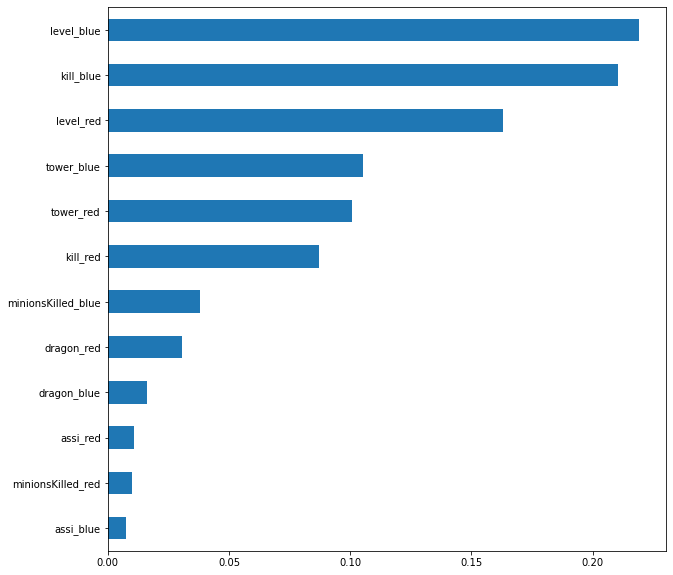

In [23]:
importances=pd.Series(xgb.feature_importances_,X_train.columns)
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh()

In [24]:
permuter=PermutationImportance(
    xgb,
    scoring='f1_weighted',
    n_iter=30,
    random_state=2)


In [25]:
permuter.fit(X_vali,y_vali)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.49123356859691997,
                                              gamma=5.1599966996832665,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.4153442468476251,
                                              max_delta_step=0, max_depth=15,
                                              min_child_weight=2, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=1100, n_jobs=4,
                                              num_parallel_tree=1,
                        

In [26]:
feature_names = X_train.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

dragon_red           -0.000960
assi_blue             0.000005
minionsKilled_blue    0.000567
assi_red              0.000677
dragon_blue           0.000803
minionsKilled_red     0.001879
tower_red             0.003935
tower_blue            0.004661
kill_red              0.005276
kill_blue             0.012085
level_blue            0.016825
level_red             0.020204
dtype: float64

In [27]:
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names 
) 
#xgb기본 feature importances와는 다를걸 예상했지만 이건 달라도 너무달라서 충격적이다 
# ttdistgame는 개인의 이동거리/각 게임당 전인원의 이동거리로 만든것인데 너무 할 정도로 높다...
# 전처리중에 아예 타겟값을 베이스로 만든 피쳐는 없었음.. 

Weight,Feature
0.0202 ± 0.0075,level_red
0.0168 ± 0.0079,level_blue
0.0121 ± 0.0071,kill_blue
0.0053 ± 0.0053,kill_red
0.0047 ± 0.0046,tower_blue
0.0039 ± 0.0050,tower_red
0.0019 ± 0.0041,minionsKilled_red
0.0008 ± 0.0032,dragon_blue
0.0007 ± 0.0036,assi_red
0.0006 ± 0.0043,minionsKilled_blue


In [28]:
""" 
추가로 변수의 중요도를 알아내어 쓸데없는걸 제거해보자
"""

' \n추가로 변수의 중요도를 알아내어 쓸데없는걸 제거해보자\n'

In [29]:
"""
좆된점 .. 15분에 탭으로 알수있는 정보가 생각보다 많이 제한적이다
알수있는 정보
K D A 타워 미니언 정글몹 용 

게임도중 알 수 없는 특성 
'totalGold','damageStats','tower_shield','goldPerSeond','junr'
이렇게되면 모은 게임데이터를 다시 플레이어별로 하면 좋을거같은데 온 길이 너무 멀어서 시간이 나면 다시하도록하고 지금 가진 자료로만 해보도록하겠다

"""


"\n좆된점 .. 15분에 탭으로 알수있는 정보가 생각보다 많이 제한적이다\n알수있는 정보\nK D A 타워 미니언 정글몹 용 \n\n게임도중 알 수 없는 특성 \n'totalGold','damageStats','tower_shield','goldPerSeond','junr'\n이렇게되면 모은 게임데이터를 다시 플레이어별로 하면 좋을거같은데 온 길이 너무 멀어서 시간이 나면 다시하도록하고 지금 가진 자료로만 해보도록하겠다\n\n"

In [30]:
data_columns=df.columns
""" 
예측시 필요한값 (순서대로)
블루레벨5 , 블루미니언5, 블루킬5,블루어시5,블루타워1,블루승패1, 레드레벨5 , 레드미니언5, 레드킬5,레드어시5,레드타워1,블루드래곤1,레드드래곤1
"""
put_data1=[9,10,11,9,8,75,77,136,96,7,2,4,3,2,0,1,4,2,3,4,0,1,11,10,10,9,8,105,80,111,118,13,3,2,4,5,1,0,3,1,3,5,1,0,1]
put_data2=[10,10,10,10,6,92,80,103,109,15,1,5,2,0,1,1,2,3,0,4,0,0,11,9,10,11,8,107,91,116,109,20,2,8,1,7,1,1,1,6,0,9,1,0,2]
put_data3=[11,9,11,8,8,111,90,116,88,28,5,2,3,0,2,1,3,1,1,2,0,1,9,10,10,11,9,93,93,94,151,24,1,5,1,7,4,0,4,2,2,8,1,0,1]
put_data4=[10,10,10,10,8,64,64,93,98,26,1,2,3,8,1,3,5,4,2,6,0,1,10,10,10,9,8,103,96,111,96,25,2,3,4,5,0,1,4,0,1,7,2,0,1]
test_test=[8,8,8,7,6,90,90,90,90,0,0,0,10,0,0,0,0,0,0,0,0,1,9,9,9,8,7,100,100,100,100,0,1,1,1,1,1,2,2,2,2,0,0,0,0]

def put_test(put):
    lp=len(put)
    dictdata={'level_blue':sum(put[:5]),
        'minionsKilled_blue':sum(put[5:10]),
        'kill_blue':sum(put[10:15]),
        'assi_blue':sum(put[15:20]),
        'tower_blue':put[20],
        'win_blue':put[21],
        'level_red':sum(put[22:27]),
        'minionsKilled_red':sum(put[27:32]),
        'kill_red':sum(put[32:37]),
        'assi_red':sum(put[37:42]),
        'tower_red':put[42],
        'dragon_blue':put[43],
        'dragon_red':put[44],
        }
    testdf = pd.DataFrame(columns=data_columns,data=dictdata,index=[0])
    y,x=split_xy(testdf)
    pred=xgb.predict_proba(x)    
    if y[0] == 1:
        z='결과: 블루승'
    else:
        z='결과: 레드승'
    return f'입력값 갯수 : {lp} 블루팀 승률 : {pred[0][1]} 레드팀 승률 : {pred[0][0]}+{z}'  

put_test(put_data1),put_test(put_data2),put_test(put_data3),put_test(put_data4),put_test(test_test)


('입력값 갯수 : 45 블루팀 승률 : 0.16442853212356567 레드팀 승률 : 0.8355714678764343+결과: 블루승',
 '입력값 갯수 : 45 블루팀 승률 : 0.07197285443544388 레드팀 승률 : 0.9280271530151367+결과: 레드승',
 '입력값 갯수 : 45 블루팀 승률 : 0.15894392132759094 레드팀 승률 : 0.8410561084747314+결과: 블루승',
 '입력값 갯수 : 45 블루팀 승률 : 0.3162885010242462 레드팀 승률 : 0.6837115287780762+결과: 블루승',
 '입력값 갯수 : 45 블루팀 승률 : 0.4031272828578949 레드팀 승률 : 0.5968726873397827+결과: 블루승')

In [35]:
import joblib
joblib.dump(xgb,'pred_lol.pkl')

['pred_lol.pkl']

In [36]:
df.columns

Index(['level_blue', 'minionsKilled_blue', 'kill_blue', 'assi_blue',
       'tower_blue', 'win_blue', 'level_red', 'minionsKilled_red', 'kill_red',
       'assi_red', 'tower_red', 'dragon_blue', 'dragon_red'],
      dtype='object')